In [3]:
%pip install numpy tensorflow


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


✅ Training set shape: X=(4940, 60, 5), y=(4940, 3)
Epoch 1/10


/Users/winnee/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0490
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 6.2213e-04
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 5.3978e-04
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 5.1495e-04
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 4.5848e-04
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 4.2789e-04
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 4.1412e-04
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 3.6850e-04
Epoch 9/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 3.5146e-04
Epoch 10/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 3.3251e-04
✅ Testing set shape: X=(6148, 60, 5), y=(6148, 3)
🕒 Predicting for 6148 hours ≈ 256.2 days
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
[[0.644426   0.6438772  0.63979906]
 [0.6432656  0.6435475  0.6406656 ]
 [0.64356846 0.64436936 0.6428087 ]
 ...
 [1.2354716  1.2416854  1.2386224 ]
 [1.2347293 

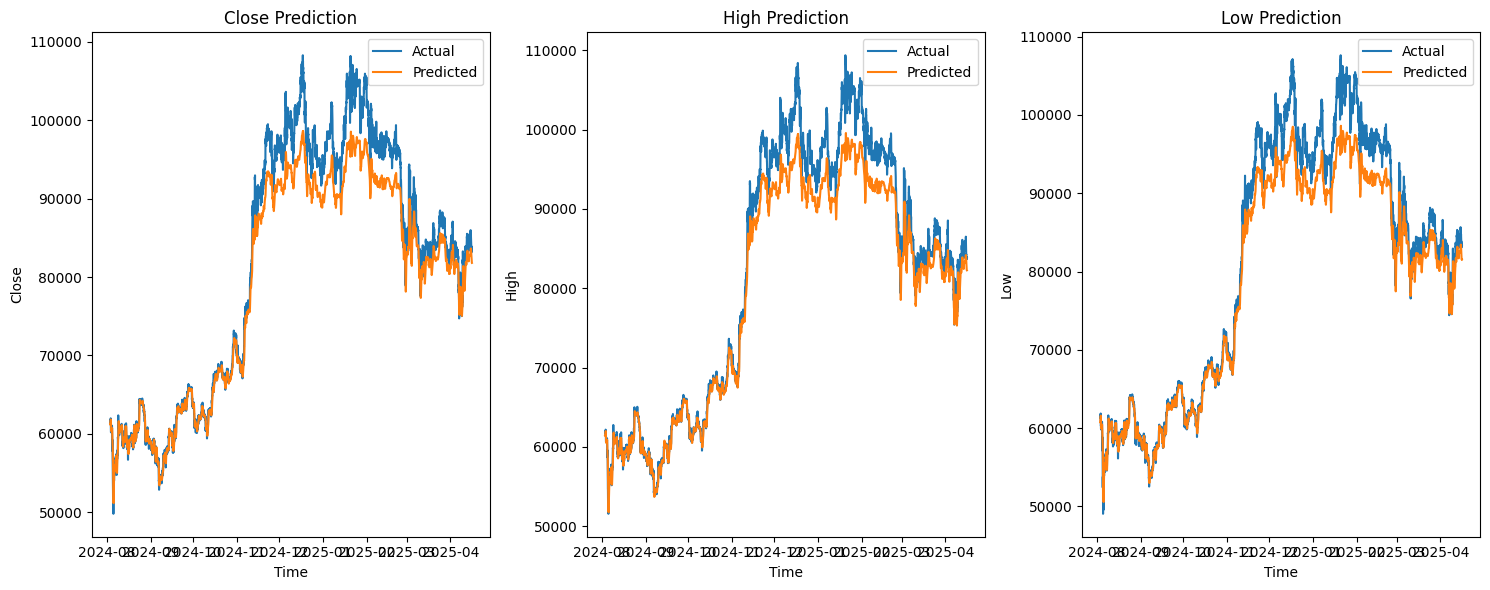

📁 Results saved to prediction_results.csv


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ========================
# CONFIG
# ========================
SEQ_LENGTH = 60
FEATURE_COLUMNS = ['open', 'high', 'low', 'close', 'volume']
TARGET_COLUMNS = ['close', 'high', 'low']
EPOCHS = 10
BATCH_SIZE = 32
TRAIN_FILE = "datasets/BTC-USD_1h_Training_data.csv"
TEST_FILE = "datasets/BTC-USD_1h_Testing_data.csv"
DATETIME_COLUMN = 'timestamp'  # Adjust this if your datetime column is named differently

# ========================
# HELPERS
# ========================
def load_data(filepath: str, features: list[str], include_time=False) -> pd.DataFrame:
    df = pd.read_csv(filepath)
    if include_time:
        df[DATETIME_COLUMN] = pd.to_datetime(df[DATETIME_COLUMN])
        return df[[DATETIME_COLUMN] + features]
    return df[features]

def normalize_data(df: pd.DataFrame, scaler: MinMaxScaler = None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df.values)
    else:
        scaled = scaler.transform(df.values)
    return scaled, scaler

def create_sequences(data: np.ndarray, target_indices: list[int], seq_length: int):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i][target_indices])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape: tuple[int, int], output_dim: int) -> Sequential:
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(64),
        Dense(output_dim)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_predictions(actual: np.ndarray, predicted: np.ndarray, columns: list[str], time_labels=None):
    plt.figure(figsize=(15, 6))
    for i, col in enumerate(columns):
        plt.subplot(1, len(columns), i + 1)
        x = time_labels if time_labels is not None else np.arange(len(actual))
        plt.plot(x, actual[:, i], label='Actual')
        plt.plot(x, predicted[:, i], label='Predicted')
        plt.title(f"{col.capitalize()} Prediction")
        plt.xlabel("Time")
        plt.ylabel(col.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

# ========================
# MAIN PIPELINE
# ========================
def run_pipeline():
    # === Load and normalize training data ===
    df_train = load_data(TRAIN_FILE, FEATURE_COLUMNS)
    scaled_train, scaler = normalize_data(df_train)

    target_indices = [FEATURE_COLUMNS.index(col) for col in TARGET_COLUMNS]
    X_train, y_train = create_sequences(scaled_train, target_indices, SEQ_LENGTH)

    print(f"✅ Training set shape: X={X_train.shape}, y={y_train.shape}")

    # === Build and train model ===
    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), output_dim=len(TARGET_COLUMNS))
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

    # === Load and normalize test data ===
    df_test = load_data(TEST_FILE, FEATURE_COLUMNS, include_time=True)
    time_labels = df_test[DATETIME_COLUMN].iloc[SEQ_LENGTH:]  # Align time with prediction steps

    df_test_no_time = df_test[FEATURE_COLUMNS]  # drop datetime for normalization
    scaled_test, _ = normalize_data(df_test_no_time, scaler)
    X_test, y_test = create_sequences(scaled_test, target_indices, SEQ_LENGTH)

    print(f"✅ Testing set shape: X={X_test.shape}, y={y_test.shape}")
    print(f"🕒 Predicting for {len(X_test)} hours ≈ {len(X_test) / 24:.1f} days")

    # === Predict and inverse transform ===
    predictions = model.predict(X_test)
    print(predictions)

    dummy = np.zeros((predictions.shape[0], len(FEATURE_COLUMNS)))
    dummy[:, target_indices] = predictions
    predicted_prices = scaler.inverse_transform(dummy)[:, target_indices]

    dummy[:, target_indices] = y_test
    actual_prices = scaler.inverse_transform(dummy)[:, target_indices]

    # === Plot results ===
    plot_predictions(actual_prices, predicted_prices, TARGET_COLUMNS, time_labels)

    # === Save results to CSV ===
    result_df = pd.DataFrame({
        DATETIME_COLUMN: time_labels,
        **{f'Normalized actual_{col}': actual_prices[:, i] for i, col in enumerate(TARGET_COLUMNS)},
        **{f'predicted_{col}': predicted_prices[:, i] for i, col in enumerate(TARGET_COLUMNS)},
    })
    result_df.to_csv("prediction_results.csv", index=False)
    print("📁 Results saved to prediction_results.csv")

# ========================
# RUN
# ========================
run_pipeline()


✅ Training set shape: X=(4940, 60, 5), y=(4940, 3)
Epoch 1/10


/Users/winnee/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0444
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 6.3915e-04
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 5.5560e-04
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 5.0199e-04
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 4.6303e-04
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 4.5611e-04
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 3.7059e-04
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 3.3638e-04
Epoch 9/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 3.7096e-04
Epoch 10/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 2.9718e-04
✅ Testing set shape: X=(6148, 60, 5), y=(6148, 3)
🕒 Predicting for 6148 hours ≈ 256.2 days
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
[[0.6605995  0.65486157 0.65269554]
 [0.66085535 0.65546143 0.65385926]
 [0.66202927 0.6567404  0.6561211 ]
 ...
 [1.269587   1.250378   1.264246  ]
 [1.2694987 

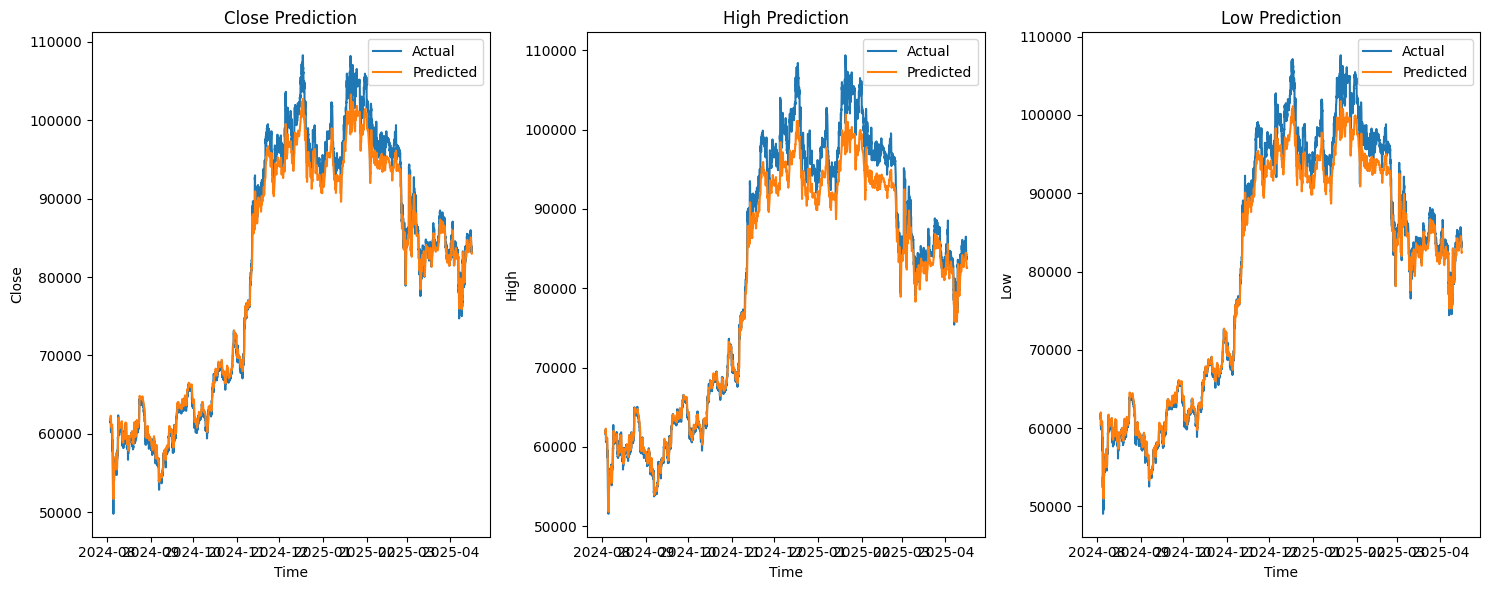

📁 Results saved to prediction_results.csv


In [7]:
df_train = load_data(TRAIN_FILE, FEATURE_COLUMNS)
scaled_train, scaler = normalize_data(df_train)

target_indices = [FEATURE_COLUMNS.index(col) for col in TARGET_COLUMNS]
X_train, y_train = create_sequences(scaled_train, target_indices, SEQ_LENGTH)

print(f"✅ Training set shape: X={X_train.shape}, y={y_train.shape}")

# === Build and train model ===
model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), output_dim=len(TARGET_COLUMNS))
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

# === Load and normalize test data ===
df_test = load_data(TEST_FILE, FEATURE_COLUMNS, include_time=True)
time_labels = df_test[DATETIME_COLUMN].iloc[SEQ_LENGTH:]  # Align time with prediction steps

df_test_no_time = df_test[FEATURE_COLUMNS]  # drop datetime for normalization
scaled_test, _ = normalize_data(df_test_no_time, scaler)
X_test, y_test = create_sequences(scaled_test, target_indices, SEQ_LENGTH)

print(f"✅ Testing set shape: X={X_test.shape}, y={y_test.shape}")
print(f"🕒 Predicting for {len(X_test)} hours ≈ {len(X_test) / 24:.1f} days")

# === Predict and inverse transform ===
predictions = model.predict(X_test)
print(predictions)
print(predictions.shape)

dummy = np.zeros((predictions.shape[0], len(FEATURE_COLUMNS)))
dummy[:, target_indices] = predictions
predicted_prices = scaler.inverse_transform(dummy)[:, target_indices]

dummy[:, target_indices] = y_test
actual_prices = scaler.inverse_transform(dummy)[:, target_indices]

# === Plot results ===
plot_predictions(actual_prices, predicted_prices, TARGET_COLUMNS, time_labels)

# === Save results to CSV ===
result_df = pd.DataFrame({
    DATETIME_COLUMN: time_labels,
    **{f'actual_{col}': actual_prices[:, i] for i, col in enumerate(TARGET_COLUMNS)},
    **{f'predicted_{col}': predicted_prices[:, i] for i, col in enumerate(TARGET_COLUMNS)},
})
result_df.to_csv("prediction_results.csv", index=False)
print("📁 Results saved to prediction_results.csv")

In [9]:
print(predictions.shape)
print(predictions)

(6148, 3)
[[0.6605995  0.65486157 0.65269554]
 [0.66085535 0.65546143 0.65385926]
 [0.66202927 0.6567404  0.6561211 ]
 ...
 [1.269587   1.250378   1.264246  ]
 [1.2694987  1.2503016  1.2647501 ]
 [1.2693253  1.2500737  1.2650821 ]]


In [10]:
print(df_test.shape)

(6208, 6)


In [1]:
import Backtesting
from Backtesting.models.lstm import LSTMModel

✅ Training set shape: X=(4940, 60, 5), y=(4940, 3)
Epoch 1/10


/Users/winnee/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0490
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 5.2989e-04
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 4.7994e-04
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 4.7402e-04
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 4.2587e-04
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 4.4341e-04
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 4.5528e-04
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 3.9939e-04
Epoch 9/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 3.2131e-04
Epoch 10/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 3.2844e-04
✅ Testing set shape: X=(6148, 60, 5), y=(6148, 3)
🕒 Predicting for 6148 hours ≈ 256.2 days
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


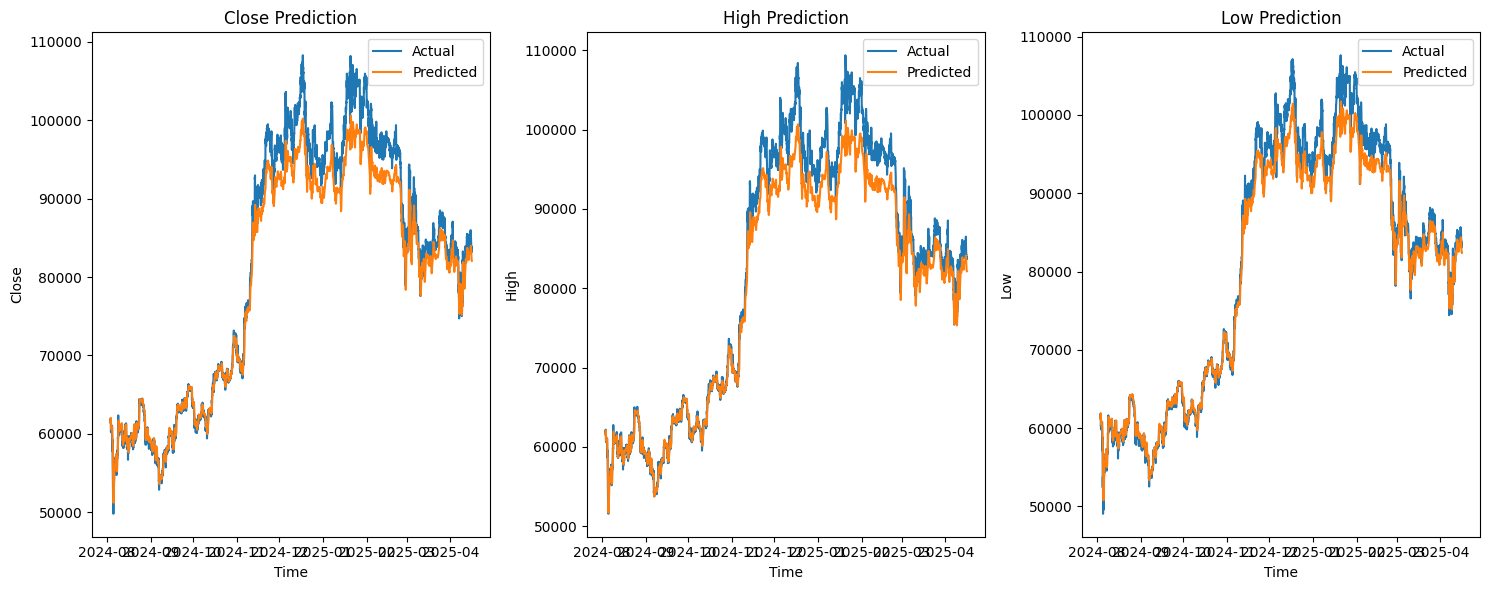

📁 Results saved to prediction_results.csv


In [2]:
lstm = LSTMModel('datasets/BTC-USD_1h_Training_data.csv')
lstm.train()
lstm.predict('datasets/BTC-USD_1h_Testing_data.csv')